# Time-of-Flight (TOF) MOT Analysis

Notebook to extract **(1) atom number**, **(2) MOT size**, and **(3) TOF physics (initial velocity, gravity, temperature)** from triggered CCD fluorescence images.

## To find:

1. For each time-of-flight $t_{m TOF}$, fit the cloud image to get the **center position** and **cloud size**.
2. Use center vs $t$ to infer **initial velocity** and check **acceleration due to gravity**.
3. Use size vs $t$ to infer the **temperature** from ballistic expansion.

---
**Assumptions:**
- Images are saved as text with a short header, then an 8‑bit pixel array.
- Each file contains one image. If the acquisition writes before/after halves stacked vertically, this notebook handles that.
- Cloud profile is approximately Gaussian in the image plane.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import optimize
import scipy.constants as c

plt.rcParams["figure.dpi"] = 120


## 1) Set experimental constants

Everything else uses these values.


In [15]:
# ---------- Imaging / geometry ----------
PIXEL_PITCH_X_M = 8.4e-6
PIXEL_PITCH_Y_M = 9.8e-6

# Magnification M = image size on sensor / object size
MAGNIFICATION = 0.5

# Camera collection geometry
LENS_RADIUS_M = 3.0e-3
DIST_MOT_TO_LENS_M = 0.320

# Optical throughput
T_OPT = 1.0

# Camera conversion + QE (Route B)
GAIN_E_PER_ADU = 1.0
QE_780 = 0.4

# Exposure time: if unknown, keep None and report N = K / t_exp.
T_EXP_S = 10e-3  # e.g. 5e-3

# ---------- MOT / scattering model ----------
M_RB85 = 85 * c.atomic_mass
GAMMA = 2*np.pi*6.07e6  # rad/s (Rb D2)

S0 = 10.8
DELTA = None           # rad/s (e.g. -2*np.pi*12e6). If None, use R_SC_USER
R_SC_USER = 2.586e6    # s^-1 (your value)

def scattering_rate(s0=S0, delta=DELTA, gamma=GAMMA):
    if delta is None:
        return float(R_SC_USER)
    return float((gamma/2.0) * (s0 / (1.0 + s0 + (2.0*delta/gamma)**2)))

ETA_GEOM = (np.pi * LENS_RADIUS_M**2 / DIST_MOT_TO_LENS_M**2) / (4*np.pi)

print(f"Omega/4pi (camera geometry) = {ETA_GEOM:.3e}")
print(f"Using R_sc = {scattering_rate():.3e} s^-1")


Omega/4pi (camera geometry) = 2.197e-05
Using R_sc = 2.586e+06 s^-1


## 2) File loader

Text files can contain header text (e.g. starting with `MOT ...`). This loader finds the numeric array.


In [16]:
def load_ccd_txt(filename: str) -> np.ndarray:
    """Load a CCD text file containing a pixel array with an optional header."""
    for skip in (0, 1, 2, 3, 4, 5, 10):
        try:
            arr = np.loadtxt(filename, dtype=float, skiprows=skip)
            if arr.ndim == 2 and arr.size > 0:
                return arr
        except Exception:
            pass

    data = np.genfromtxt(filename, dtype=float, invalid_raise=False)
    if data.ndim != 2:
        raise ValueError(f"Could not parse a 2D numeric array from {filename}.")
    data = data[~np.isnan(data).all(axis=1)]
    return data


## 3) Split before/after shutter (if present)

If the acquisition saves two frames stacked vertically, this returns:
- `before_shutter`: top half
- `after_shutter`: bottom half

If the file contains only one frame, it returns only `after_shutter`.


In [17]:
def split_before_after(img: np.ndarray, *, assume_two_frames: bool = True):
    ny, nx = img.shape
    if not assume_two_frames:
        return {"before_shutter": img}

    if ny >= 2*200:
        mid = ny // 2
        return {"after_shutter": img[:mid, :], "before_shutter": img[mid:, :]}
    return {"before_shutter": img}


## 4) 2D Gaussian fit (rotated)

We fit:
$$
I(x,y)=B + A\exp\left(-\tfrac12\left[(x')^2/\sigma_x^2 + (y')^2/\sigma_y^2\right]\right).
$$

For absolute atom number, we use a raw-sum integral over the fit ROI:
$$
S_{\rm ADU} = \sum_{\rm ROI}(I - B).
$$


In [18]:
def gaussian2d_rot(coords, A, x0, y0, sx, sy, theta, B):
    x, y = coords
    ct, st = np.cos(theta), np.sin(theta)
    xp =  ct*(x-x0) + st*(y-y0)
    yp = -st*(x-x0) + ct*(y-y0)
    return B + A*np.exp(-0.5*((xp/sx)**2 + (yp/sy)**2))

def fit_gaussian2d(img: np.ndarray, roi=None):
    ny, nx = img.shape
    if roi is None:
        x0, x1, y0, y1 = 0, nx, 0, ny
    else:
        x0, x1, y0, y1 = roi
        x0, x1 = int(max(0, x0)), int(min(nx, x1))
        y0, y1 = int(max(0, y0)), int(min(ny, y1))
    if x1 <= x0 or y1 <= y0:
        raise ValueError(f"Invalid ROI {roi} for image shape {img.shape}")

    roi_img = img[y0:y1, x0:x1].astype(float)
    yy, xx = np.mgrid[y0:y1, x0:x1]
    coords = (xx.ravel(), yy.ravel())
    z = roi_img.ravel()

    B0 = np.median(roi_img)
    A0 = float(np.max(roi_img) - B0)
    iy, ix = np.unravel_index(np.argmax(roi_img), roi_img.shape)
    x00 = x0 + ix
    y00 = y0 + iy
    sx0 = max(2.0, 0.15*(x1-x0))
    sy0 = max(2.0, 0.15*(y1-y0))
    th0 = 0.0

    p0 = (A0, x00, y00, sx0, sy0, th0, B0)
    bounds = ((0, 0, 0, 0.5, 0.5, -np.pi/2, -np.inf),
              (np.inf, nx, ny, np.inf, np.inf,  np.pi/2,  np.inf))

    popt, pcov = optimize.curve_fit(gaussian2d_rot, coords, z, p0=p0, bounds=bounds, maxfev=20000)
    perr = np.sqrt(np.diag(pcov))

    A, x0f, y0f, sx, sy, theta, B = popt
    out = {
        "Amplitude_Value": float(A),
        "x0_Value": float(x0f),
        "y0_Value": float(y0f),
        "w0x_Value": float(sx),
        "w0y_Value": float(sy),
        "Orientation_Value": float(theta),
        "Offset_Value": float(B),
        "Amplitude_Sigma": float(perr[0]),
        "x0_Sigma": float(perr[1]),
        "y0_Sigma": float(perr[2]),
        "w0x_Sigma": float(perr[3]),
        "w0y_Sigma": float(perr[4]),
        "Orientation_Sigma": float(perr[5]),
        "Offset_Sigma": float(perr[6]),
    }
    return out, (x0, x1, y0, y1), roi_img


## 5) Per-file analysis: MOT size + atom number

Atom number given by:
$$
N = \frac{S_{\rm ADU} g_{e/\rm ADU}}{\mathrm{QE}\,T_{\rm opt}\,(\Omega/4\pi)\,R_{\rm sc}\,t_{\rm exp}}.
$$

If `T_EXP_S=None`, the notebook reports $K$ where $N = K/t_{\rm exp}$.


In [27]:
# ---------- ROI sum + Poisson uncertainty ----------

def roi_sum_counts(img: np.ndarray, roi, offset=None) -> tuple[float, float, int]:
    """
    Background-subtracted ROI sum in ADU, plus an uncertainty estimate.

    Model:
      - Treat each pixel's ADU as proportional to detected photoelectrons.
      - Shot noise: Var(e-) ≈ N_e-
      - Convert back to ADU using (GAIN_E_PER_ADU)
      - If you pass an offset (background level), we also include background shot noise
        from the ROI pixels via offset * n_pix (in ADU). This is an approximation but
        captures the right scaling fast.

    Returns
    -------
    S_ADU : float
        Sum over ROI of (img - offset) in ADU.
    sS_ADU : float
        1σ uncertainty on S_ADU in ADU (shot-noise dominated approximation).
    n_pix : int
        Number of pixels in ROI.
    """
    x0, x1, y0, y1 = roi
    sub = img[y0:y1, x0:x1].astype(float)
    n_pix = sub.size

    if offset is None:
        S_ADU = float(np.sum(sub))
        # Shot noise from signal only
        Ne = max(S_ADU, 0.0) * GAIN_E_PER_ADU
        sS_ADU = np.sqrt(max(Ne, 0.0)) / GAIN_E_PER_ADU
        return S_ADU, float(sS_ADU), int(n_pix)

    B = float(offset)
    S_ADU = float(np.sum(sub - B))

    # Approximate total detected electrons contributing to shot noise:
    # signal electrons (only positive part) + background electrons in ROI
    # Use clip to avoid negative "counts" producing imaginary sigma.
    Spos_ADU = float(np.sum(np.clip(sub - B, 0, None)))
    Ne_signal = Spos_ADU * GAIN_E_PER_ADU
    Ne_bkg = max(B, 0.0) * n_pix * GAIN_E_PER_ADU

    sS_ADU = np.sqrt(max(Ne_signal + Ne_bkg, 0.0)) / GAIN_E_PER_ADU
    return S_ADU, float(sS_ADU), int(n_pix)


def px_to_object_m(px, *, pitch_m, magnification):
    """Convert pixel units to object-plane meters."""
    return px * pitch_m / magnification


def _fit_sigma_or_default(fit: dict, key_sigma: str, default_px: float = 0.5) -> float:
    """Grab fit-reported 1σ (in px) or fall back to a conservative default."""
    try:
        v = float(fit.get(key_sigma, np.nan))
        if np.isfinite(v) and v > 0:
            return v
    except Exception:
        pass
    return float(default_px)


def _prop_atom_number_errors(
    S_ADU: float,
    sS_ADU: float,
    R_sc: float,
    *,
    rel_QE: float = 0.20,
    rel_Topt: float = 0.20,
    rel_eta: float = 0.20,
    rel_Rsc: float = 0.15,
    rel_gain: float = 0.10,
    rel_texp: float = 0.10,
):
    """
    Route B: N = K_atoms_s / t_exp, with
      K_atoms_s = (S_ADU * GAIN_E_PER_ADU) / (QE_780 * T_OPT * ETA_GEOM * R_sc)

    We treat:
      - sS_ADU from shot noise (above)
      - and optional systematic fractional uncertainties for QE, optics transmission, geometry,
        scattering rate, and gain (e-/ADU), exposure time.
    """
    denom = QE_780 * T_OPT * ETA_GEOM * R_sc
    K_atoms_s = (S_ADU * GAIN_E_PER_ADU) / denom

    # Fractional statistical from S_ADU (and optionally gain)
    rel_S = 0.0 if (S_ADU == 0) else abs(sS_ADU / S_ADU)

    rel_tot_K = np.sqrt(
        rel_S**2 +
        rel_gain**2 +
        rel_QE**2 +
        rel_Topt**2 +
        rel_eta**2 +
        rel_Rsc**2
    )
    sK_atoms_s = abs(K_atoms_s) * rel_tot_K

    if T_EXP_S is None:
        return K_atoms_s, sK_atoms_s, None, None

    Natoms = K_atoms_s / T_EXP_S
    # include exposure-time fractional uncertainty
    rel_tot_N = np.sqrt(rel_tot_K**2 + rel_texp**2)
    sNatoms = abs(Natoms) * rel_tot_N

    return K_atoms_s, sK_atoms_s, Natoms, sNatoms


# ---------- main: analyze one file with position + atom-number errors ----------

def analyze_file(
    filename: str,
    *,
    roi_before=None,
    roi_after=None,
    show_compare: bool = True,
    assume_two_frames: bool = True,
    default_pos_sigma_px: float = 0.5,
):
    """
    Analyze one TOF file with:
      - fit-reported position errors (x0_Sigma, y0_Sigma) in px (fallback if missing)
      - ROI-sum shot-noise (Poisson-ish) error model
      - propagated Route-B atom-number errors

    Returns a dict with:
      - fit centers + 1σ errors (px and m)
      - widths (mm)
      - S_ADU ± sS_ADU
      - K_atoms_s ± sK_atoms_s
      - Natoms ± sNatoms (if T_EXP_S is set)
    """
    img_full = load_ccd_txt(filename)
    regions = split_before_after(img_full, assume_two_frames=assume_two_frames)
    fname = Path(filename).name

    # --- Visualization
    if show_compare and ("before_shutter" in regions):
        fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
        ax[0].imshow(regions["before_shutter"], cmap="gray", vmin=0, vmax=255)
        ax[0].set_title(f"Before shutter: {fname}")
        ax[0].axis("off")
        ax[1].imshow(regions["after_shutter"], cmap="gray", vmin=0, vmax=255)
        ax[1].set_title(f"After shutter: {fname}")
        ax[1].axis("off")
        plt.show()
    elif show_compare:
        plt.figure(figsize=(5, 4))
        plt.imshow(regions["after_shutter"], cmap="gray", vmin=0, vmax=255)
        plt.title(f"Image: {fname}")
        plt.axis("off")
        plt.show()

    # --- Fits
    after_img = regions["after_shutter"]
    fit_after, roi_after_used, _ = fit_gaussian2d(after_img, roi=roi_after)

    fit_before = None
    roi_before_used = None
    if "before_shutter" in regions:
        before_img = regions["before_shutter"]
        fit_before, roi_before_used, _ = fit_gaussian2d(before_img, roi=roi_before)

    # --- Position uncertainties in px (from fitter if available)
    sx0_after_px = _fit_sigma_or_default(fit_after, "x0_Sigma", default_pos_sigma_px)
    sy0_after_px = _fit_sigma_or_default(fit_after, "y0_Sigma", default_pos_sigma_px)

    sx0_before_px = np.nan
    sy0_before_px = np.nan
    if fit_before is not None:
        sx0_before_px = _fit_sigma_or_default(fit_before, "x0_Sigma", default_pos_sigma_px)
        sy0_before_px = _fit_sigma_or_default(fit_before, "y0_Sigma", default_pos_sigma_px)

    # --- Convert centers + errors to object-plane meters (for later velocity/gravity fits)
    px_to_mx = PIXEL_PITCH_X_M / MAGNIFICATION
    px_to_my = PIXEL_PITCH_Y_M / MAGNIFICATION

    x0_after_px = float(fit_after["x0_Value"])
    y0_after_px = float(fit_after["y0_Value"])
    x0_after_m = px_to_object_m(x0_after_px, pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION)
    y0_after_m = px_to_object_m(y0_after_px, pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION)
    sx0_after_m = px_to_object_m(sx0_after_px, pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION)
    sy0_after_m = px_to_object_m(sy0_after_px, pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION)

    x0_before_px = np.nan
    y0_before_px = np.nan
    x0_before_m = np.nan
    y0_before_m = np.nan
    sx0_before_m = np.nan
    sy0_before_m = np.nan
    if fit_before is not None:
        x0_before_px = float(fit_before["x0_Value"])
        y0_before_px = float(fit_before["y0_Value"])
        x0_before_m = px_to_object_m(x0_before_px, pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION)
        y0_before_m = px_to_object_m(y0_before_px, pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION)
        sx0_before_m = px_to_object_m(sx0_before_px, pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION)
        sy0_before_m = px_to_object_m(sy0_before_px, pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION)

    # --- Widths to object-plane mm (consistent with your earlier "waist" convention)
    waist_after_x_mm = 2.0 * px_to_object_m(float(fit_after["w0x_Value"]), pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION) * 1e3
    waist_after_y_mm = 2.0 * px_to_object_m(float(fit_after["w0y_Value"]), pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION) * 1e3

    waist_before_x_mm = np.nan
    waist_before_y_mm = np.nan
    if fit_before is not None:
        waist_before_x_mm = 2.0 * px_to_object_m(float(fit_before["w0x_Value"]), pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION) * 1e3
        waist_before_y_mm = 2.0 * px_to_object_m(float(fit_before["w0y_Value"]), pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION) * 1e3

    # --- ROI sum + shot-noise uncertainty (ADU)
    offset_after = float(fit_after["Offset_Value"])
    S_ADU, sS_ADU, n_pix = roi_sum_counts(after_img, roi_after_used, offset=offset_after)

    # --- Atom number + propagated errors (Route B)
    R_sc = scattering_rate()
    K_atoms_s, sK_atoms_s, Natoms, sNatoms = _prop_atom_number_errors(S_ADU, sS_ADU, R_sc)

    out = {
        "file": fname,
        "t_s": np.nan,  # filled later

        "img_shape": tuple(after_img.shape),
        "img_max": float(np.max(after_img)),
        "img_mean": float(np.mean(after_img)),

        # Pixel->meter scaling (useful downstream)
        "px_to_mx": float(px_to_mx),
        "px_to_my": float(px_to_my),

        # AFTER fit centers + errors
        "x0_after_px": x0_after_px,
        "y0_after_px": y0_after_px,
        "sx0_after_px": float(sx0_after_px),
        "sy0_after_px": float(sy0_after_px),
        "x0_after_m": float(x0_after_m),
        "y0_after_m": float(y0_after_m),
        "sx0_after_m": float(sx0_after_m),
        "sy0_after_m": float(sy0_after_m),

        # BEFORE fit centers + errors (if available)
        "x0_before_px": float(x0_before_px) if np.isfinite(x0_before_px) else np.nan,
        "y0_before_px": float(y0_before_px) if np.isfinite(y0_before_px) else np.nan,
        "sx0_before_px": float(sx0_before_px) if np.isfinite(sx0_before_px) else np.nan,
        "sy0_before_px": float(sy0_before_px) if np.isfinite(sy0_before_px) else np.nan,
        "x0_before_m": float(x0_before_m) if np.isfinite(x0_before_m) else np.nan,
        "y0_before_m": float(y0_before_m) if np.isfinite(y0_before_m) else np.nan,
        "sx0_before_m": float(sx0_before_m) if np.isfinite(sx0_before_m) else np.nan,
        "sy0_before_m": float(sy0_before_m) if np.isfinite(sy0_before_m) else np.nan,

        # Widths used for temperature (mm)
        "waist_after_x_mm": float(waist_after_x_mm),
        "waist_after_y_mm": float(waist_after_y_mm),
        "waist_before_x_mm": float(waist_before_x_mm) if np.isfinite(waist_before_x_mm) else np.nan,
        "waist_before_y_mm": float(waist_before_y_mm) if np.isfinite(waist_before_y_mm) else np.nan,

        # Camera signal and uncertainties
        "S_ADU": float(S_ADU),
        "sS_ADU": float(sS_ADU),
        "roi_npix": int(n_pix),

        # Atom number scaling and uncertainties
        "K_atoms_s": float(K_atoms_s),
        "sK_atoms_s": float(sK_atoms_s),
        "Natoms": None if Natoms is None else float(Natoms),
        "sNatoms": None if sNatoms is None else float(sNatoms),

        # ROIs
        "roi_after": tuple(roi_after_used),
        "roi_before": None if roi_before_used is None else tuple(roi_before_used),

        # Keep fit dicts
        "fit_after": fit_after,
        "fit_before": fit_before,
    }

    if fit_before is not None:
        out.update({
            "w0x_before_px": float(fit_before["w0x_Value"]),
            "w0y_before_px": float(fit_before["w0y_Value"]),
        })
    out.update({
        "w0x_after_px": float(fit_after["w0x_Value"]),
        "w0y_after_px": float(fit_after["w0y_Value"]),
    })

    return out


## 6) Run on one file (sanity check)

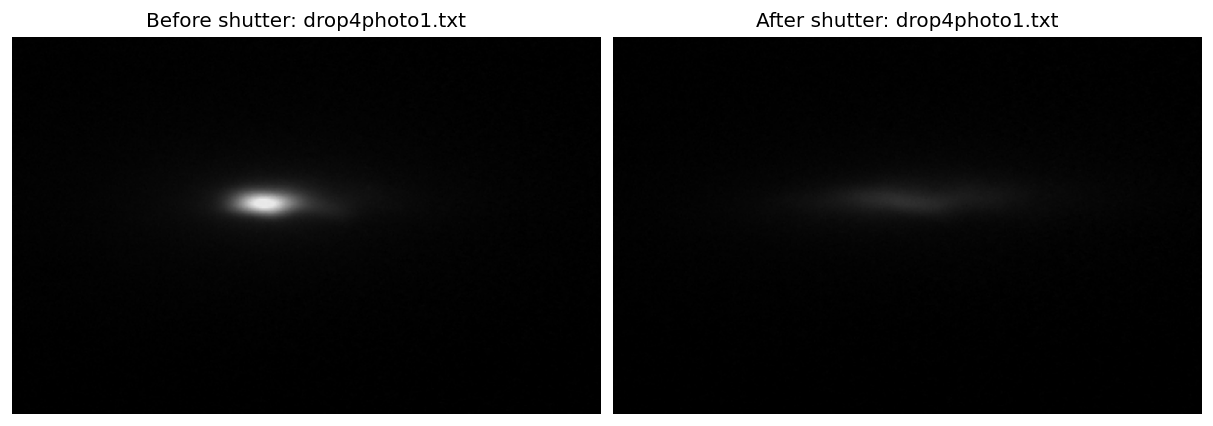

,file,t (ms),shape,max ADU,mean ADU,x0_before (px),y0_before (px),x0_after (px),y0_after (px),σx0_before (px),...,waist_before_y (mm),waist_after_x (mm),waist_after_y (mm),S_ADU,σS_ADU,ROI pixels,K (atoms·s),σK (atoms·s),Natoms,σNatoms
0,drop4photo1.txt,NaN,"(246, 384)",50.0,2.858856,165.202156,108.032193,193.818433,105.865219,0.019743,...,0.237771,1.841749,0.424047,128526.893992,561.360271,94464,5654.874085,2208.437039,565487.408472,227968.641802


In [28]:
filename = "drop4photo1.txt"  # change as needed
res1 = analyze_file(
    filename,
    show_compare=True,
    assume_two_frames=True,
)

pd.DataFrame([{
    "file": res1["file"],
    "t (ms)": np.nan if np.isnan(res1["t_s"]) else res1["t_s"] * 1e3,
    "shape": res1["img_shape"],
    "max ADU": res1["img_max"],
    "mean ADU": res1["img_mean"],

    # --- Positions (px) ---
    "x0_before (px)": res1["x0_before_px"],
    "y0_before (px)": res1["y0_before_px"],
    "x0_after (px)":  res1["x0_after_px"],
    "y0_after (px)":  res1["y0_after_px"],

    # --- Position uncertainties (px) ---
    "σx0_before (px)": res1.get("sx0_before_px", np.nan),
    "σy0_before (px)": res1.get("sy0_before_px", np.nan),
    "σx0_after (px)":  res1["sx0_after_px"],
    "σy0_after (px)":  res1["sy0_after_px"],

    # --- Cloud sizes (mm) ---
    "waist_before_x (mm)": res1["waist_before_x_mm"],
    "waist_before_y (mm)": res1["waist_before_y_mm"],
    "waist_after_x (mm)":  res1["waist_after_x_mm"],
    "waist_after_y (mm)":  res1["waist_after_y_mm"],

    # --- Camera signal ---
    "S_ADU": res1["S_ADU"],
    "σS_ADU": res1["sS_ADU"],
    "ROI pixels": res1["roi_npix"],

    # --- Atom number (Route B) ---
    "K (atoms·s)": res1["K_atoms_s"],
    "σK (atoms·s)": res1["sK_atoms_s"],
    "Natoms": res1.get("Natoms", np.nan),
    "σNatoms": res1.get("sNatoms", np.nan),
}])


In [29]:
print(res1["waist_before_x_mm"])
print(res1["waist_before_y_mm"])
print(res1["waist_after_x_mm"])
print(res1["waist_after_y_mm"])

0.5686044207640482
0.2377706911769545
1.8417493389682709
0.4240470636914344


## 7) TOF sweep: analyze many files

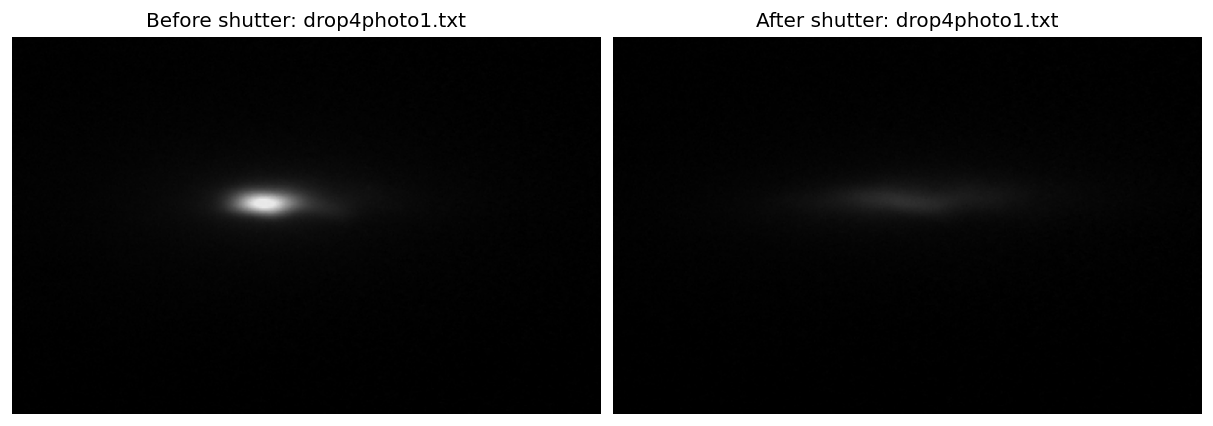

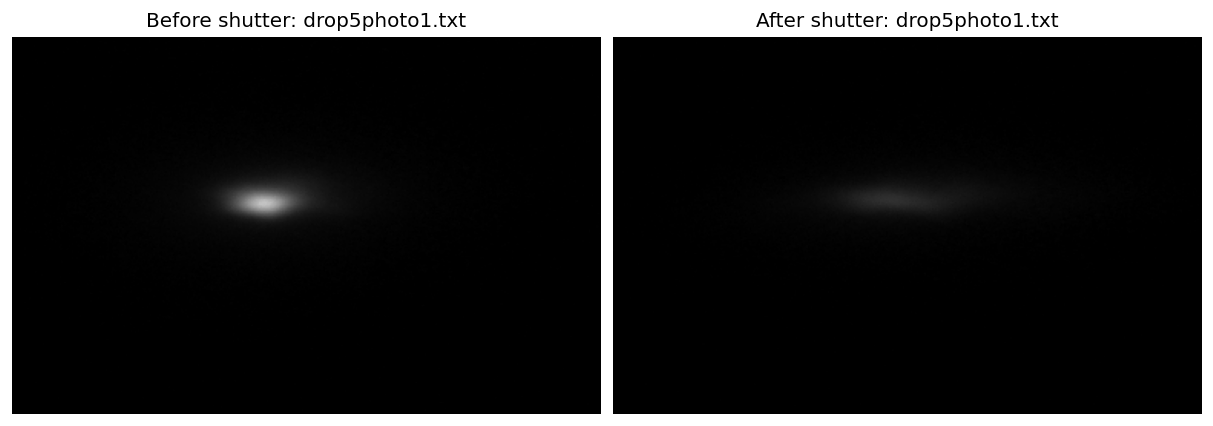

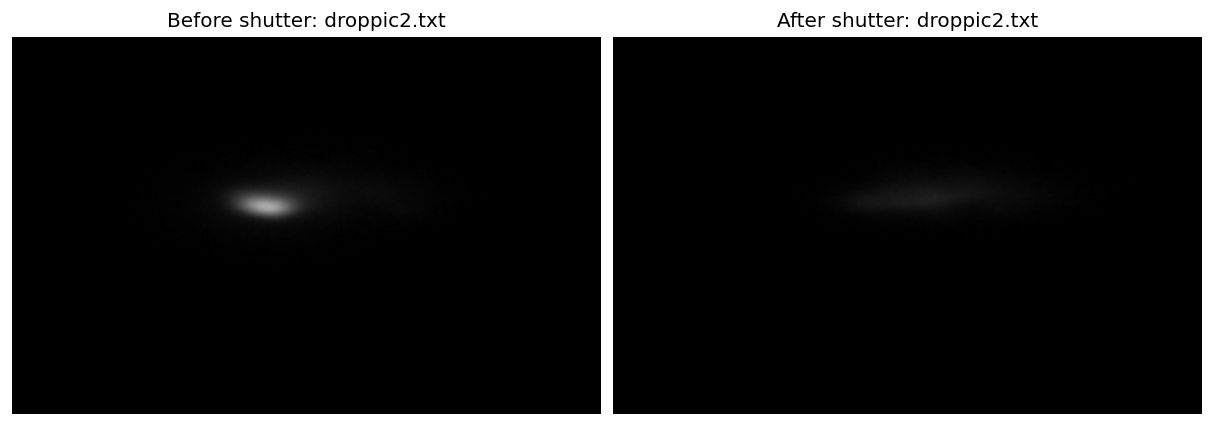

,file,t (ms),shape,max ADU,mean ADU,x0_before (px),y0_before (px),x0_after (px),y0_after (px),σx0_before (px),...,waist_before_y (mm),waist_after_x (mm),waist_after_y (mm),S_ADU,σS_ADU,ROI pixels,K (atoms·s),σK (atoms·s),Natoms,σNatoms
0,droppic2.txt,10.0,"(246, 384)",33.0,0.635808,165.882276,109.346146,206.556467,103.727857,0.016699,...,0.227697,1.314429,0.340072,56988.031965,250.624936,94464,2507.336287,979.208210,250733.628651,101079.971860
1,drop4photo1.txt,12.0,"(246, 384)",50.0,2.858856,165.202156,108.032193,193.818433,105.865219,0.019743,...,0.237771,1.841749,0.424047,128526.893992,561.360271,94464,5654.874085,2208.437039,565487.408472,227968.641802
2,drop5photo1.txt,15.0,"(246, 384)",50.0,1.317645,164.534305,107.380907,188.504018,105.463926,0.018665,...,0.274529,1.367833,0.360782,89041.512751,386.569738,94464,3917.612317,1529.971056,391761.231660,157933.159740


In [30]:
tof_dataset = [
    ("drop4photo1.txt", 12e-3),
    ("drop5photo1.txt", 15e-3),
    ("droppic2.txt",    10e-3),
]

def analyze_tof_dataset(
    tof_dataset,
    *,
    roi_before=None,
    roi_after=None,
    assume_two_frames=True,
    show_compare=True,
):
    rows = []
    for fn, t in tof_dataset:
        r = analyze_file(
            fn,
            roi_before=roi_before,
            roi_after=roi_after,
            show_compare=show_compare,
            assume_two_frames=assume_two_frames,
        )
        r["t_s"] = float(t)
        rows.append(r)

    return (
        pd.DataFrame(rows)
        .sort_values("t_s")
        .reset_index(drop=True)
    )

df = analyze_tof_dataset(tof_dataset, show_compare=True)

pd.DataFrame({
    # --- File & timing ---
    "file": df["file"],
    "t (ms)": df["t_s"] * 1e3,

    # --- Image diagnostics ---
    "shape": df["img_shape"],
    "max ADU": df["img_max"],
    "mean ADU": df["img_mean"],

    # --- Positions (px) ---
    "x0_before (px)": df["x0_before_px"],
    "y0_before (px)": df["y0_before_px"],
    "x0_after (px)":  df["x0_after_px"],
    "y0_after (px)":  df["y0_after_px"],

    # --- Position uncertainties (px) ---
    "σx0_before (px)": df.get("sx0_before_px", np.nan),
    "σy0_before (px)": df.get("sy0_before_px", np.nan),
    "σx0_after (px)":  df["sx0_after_px"],
    "σy0_after (px)":  df["sy0_after_px"],

    # --- Cloud sizes (mm) ---
    "waist_before_x (mm)": df["waist_before_x_mm"],
    "waist_before_y (mm)": df["waist_before_y_mm"],
    "waist_after_x (mm)":  df["waist_after_x_mm"],
    "waist_after_y (mm)":  df["waist_after_y_mm"],

    # --- Camera signal ---
    "S_ADU": df["S_ADU"],
    "σS_ADU": df["sS_ADU"],
    "ROI pixels": df["roi_npix"],

    # --- Atom number (Route B) ---
    "K (atoms·s)": df["K_atoms_s"],
    "σK (atoms·s)": df["sK_atoms_s"],
    "Natoms": df.get("Natoms", np.nan),
    "σNatoms": df.get("sNatoms", np.nan),
})


## 8) TOF physics: velocity, gravity, temperature

In [31]:
def _to_float_arr(s):
    return pd.to_numeric(s, errors="coerce").to_numpy(dtype=float)

def fit_line_wls(x, y, sy):
    """
    Weighted least squares for y = a + b x with pointwise uncertainties sy.
    Returns (a, b, sa, sb, cov_ab).
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    sy = np.asarray(sy, float)

    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(sy) & (sy > 0)
    x, y, sy = x[m], y[m], sy[m]
    if len(x) < 2:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    w = 1.0 / sy**2
    A = np.vstack([np.ones_like(x), x]).T
    ATA = A.T @ (w[:, None] * A)
    ATy = A.T @ (w * y)
    coef = np.linalg.solve(ATA, ATy)  # [a, b]
    cov = np.linalg.inv(ATA)
    a, b = coef
    sa, sb = np.sqrt(np.diag(cov))
    return float(a), float(b), float(sa), float(sb), cov

def fit_y_gravity_wls(t, y, sy):
    """
    Weighted least squares for y(t) = y0 + vy t - 0.5 g t^2.
    Linearize with parameter c = (-0.5 g):
        y = y0 + vy t + c t^2
    Solve for (y0, vy, c) with WLS, then g = -2c.
    Returns (y0, vy, g, sy0, svy, sg).
    """
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    sy = np.asarray(sy, float)

    m = np.isfinite(t) & np.isfinite(y) & np.isfinite(sy) & (sy > 0)
    t, y, sy = t[m], y[m], sy[m]
    if len(t) < 3:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    w = 1.0 / sy**2
    A = np.vstack([np.ones_like(t), t, t**2]).T  # [y0, vy, c]
    ATA = A.T @ (w[:, None] * A)
    ATy = A.T @ (w * y)
    coef = np.linalg.solve(ATA, ATy)
    cov = np.linalg.inv(ATA)

    y0, vy, ccoef = coef
    sy0, svy, sc = np.sqrt(np.diag(cov))

    g = -2.0 * ccoef
    sg = 2.0 * sc
    return float(y0), float(vy), float(g), float(sy0), float(svy), float(sg)

def _sigma_from_fitdict(fit_dict, value_key, sigma_key, default_sigma_px=0.5):
    """
    Grab a fit sigma if present; otherwise fallback.
    """
    if fit_dict is None:
        return np.nan
    try:
        s = float(fit_dict.get(sigma_key, np.nan))
        if np.isfinite(s) and s > 0:
            return s
    except Exception:
        pass
    return float(default_sigma_px)

def tof_physics_consistent_with_errors(
    df: pd.DataFrame,
    *,
    use_after=True,
    pos_sigma_floor_px=0.5,
    width_sigma_floor_px=0.5,
):
    """
    Same physics as your earlier method, but with error propagation:

    - vx: WLS fit to x_after(t) with σx from sx0_after_m (or computed from sx0_after_px)
    - vy, g: WLS fit to y_after(t) with σy
    - T per file: propagate σw from w0x_Sigma/w0y_Sigma (fit dict) into Tx, Ty

    Returns a one-row DataFrame with best fits + uncertainties + per-file T ± σT.
    """
    if len(df) < 3:
        raise ValueError("Need at least 3 TOF points to fit velocities and gravity robustly.")

    d = df.copy()

    # --- time
    t = _to_float_arr(d["t_s"])

    # --- choose centers + sigmas (px)
    if use_after:
        x_px = _to_float_arr(d["x0_after_px"])
        y_px = _to_float_arr(d["y0_after_px"])
        sx_px = _to_float_arr(d.get("sx0_after_px", pd.Series(np.nan, index=d.index)))
        sy_px = _to_float_arr(d.get("sy0_after_px", pd.Series(np.nan, index=d.index)))
    else:
        x_px = _to_float_arr(d["x0_before_px"])
        y_px = _to_float_arr(d["y0_before_px"])
        sx_px = _to_float_arr(d.get("sx0_before_px", pd.Series(np.nan, index=d.index)))
        sy_px = _to_float_arr(d.get("sy0_before_px", pd.Series(np.nan, index=d.index)))

    # enforce sigma floor in px (so weights don't go crazy)
    sx_px = np.where(np.isfinite(sx_px) & (sx_px > 0), sx_px, pos_sigma_floor_px)
    sy_px = np.where(np.isfinite(sy_px) & (sy_px > 0), sy_px, pos_sigma_floor_px)
    sx_px = np.maximum(sx_px, pos_sigma_floor_px)
    sy_px = np.maximum(sy_px, pos_sigma_floor_px)

    # --- convert to meters + meter sigmas
    x_m = px_to_object_m(x_px, pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION)
    y_m = px_to_object_m(y_px, pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION)
    sx_m = px_to_object_m(sx_px, pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION)
    sy_m = px_to_object_m(sy_px, pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION)

    # remove bad rows for motion fits
    good_motion = np.isfinite(t) & np.isfinite(x_m) & np.isfinite(y_m) & np.isfinite(sx_m) & np.isfinite(sy_m) & (sx_m > 0) & (sy_m > 0)
    t_fit = t[good_motion]
    x_fit = x_m[good_motion]
    y_fit = y_m[good_motion]
    sx_fit = sx_m[good_motion]
    sy_fit = sy_m[good_motion]

    if len(t_fit) < 3:
        raise ValueError("After filtering, fewer than 3 valid TOF points remain for vx/vy/g fit.")

    # --- vx (WLS line)
    x0, vx, sx0, svx, _ = fit_line_wls(t_fit, x_fit, sx_fit)

    # --- vy + g (WLS quadratic)
    y0, vy, gfit, sy0, svy, sg = fit_y_gravity_wls(t_fit, y_fit, sy_fit)

    # ---------------- Temperature with propagated errors ----------------
    # Your convention (kept exactly):
    #   wxf = waist_after_x_mm * 2 * 1e-3  (meters)
    #   wxi = waist_before_x_mm * 2 * 1e-3  (meters)
    #   Tx = m (wxf^2 - wxi^2) / (3 k t^2)
    m_rb85 = 85 * c.atomic_mass

    wxf = _to_float_arr(d["waist_after_x_mm"]) * 2 * 1e-3
    wyf = _to_float_arr(d["waist_after_y_mm"]) * 2 * 1e-3
    wxi = _to_float_arr(d["waist_before_x_mm"]) * 2 * 1e-3
    wyi = _to_float_arr(d["waist_before_y_mm"]) * 2 * 1e-3

    # need per-file width sigmas. Best: pull from fit dicts w0x_Sigma, w0y_Sigma, then map to waist mm.
    # waist_mm = 2 * (w0_px * pitch/mag)*1e3  =>  d(waist_mm)/d(w0_px) = 2*(pitch/mag)*1e3
    d_waistx_mm_dw0x = 2.0 * (PIXEL_PITCH_X_M / MAGNIFICATION) * 1e3
    d_waisty_mm_dw0y = 2.0 * (PIXEL_PITCH_Y_M / MAGNIFICATION) * 1e3

    # default width sigmas (px) if not available
    sw0x_after_px = np.full(len(d), width_sigma_floor_px, float)
    sw0y_after_px = np.full(len(d), width_sigma_floor_px, float)
    sw0x_before_px = np.full(len(d), width_sigma_floor_px, float)
    sw0y_before_px = np.full(len(d), width_sigma_floor_px, float)

    # If fit dicts exist, use them
    if "fit_after" in d.columns:
        for i, fd in enumerate(d["fit_after"]):
            if isinstance(fd, dict):
                sw0x_after_px[i] = _sigma_from_fitdict(fd, "w0x_Value", "w0x_Sigma", width_sigma_floor_px)
                sw0y_after_px[i] = _sigma_from_fitdict(fd, "w0y_Value", "w0y_Sigma", width_sigma_floor_px)
    if "fit_before" in d.columns:
        for i, fd in enumerate(d["fit_before"]):
            if isinstance(fd, dict):
                sw0x_before_px[i] = _sigma_from_fitdict(fd, "w0x_Value", "w0x_Sigma", width_sigma_floor_px)
                sw0y_before_px[i] = _sigma_from_fitdict(fd, "w0y_Value", "w0y_Sigma", width_sigma_floor_px)

    # convert waist-mm sigmas to meter sigmas of your w variables (remember you multiply by 2*1e-3 later)
    # σ(waist_mm) = d_waist_mm/dw0 * σ(w0_px)
    swaist_after_x_mm = d_waistx_mm_dw0x * sw0x_after_px
    swaist_after_y_mm = d_waisty_mm_dw0y * sw0y_after_px
    swaist_before_x_mm = d_waistx_mm_dw0x * sw0x_before_px
    swaist_before_y_mm = d_waisty_mm_dw0y * sw0y_before_px

    # σ(w_meters) where w = waist_mm * 2 * 1e-3
    swxf = swaist_after_x_mm * 2 * 1e-3
    swyf = swaist_after_y_mm * 2 * 1e-3
    swxi = swaist_before_x_mm * 2 * 1e-3
    swyi = swaist_before_y_mm * 2 * 1e-3

    # valid temps require before widths
    validT = np.isfinite(t) & np.isfinite(wxf) & np.isfinite(wyf) & np.isfinite(wxi) & np.isfinite(wyi)
    if not np.all(validT):
        raise ValueError("Some rows missing before_shutter widths; ensure assume_two_frames=True and fits succeeded.")

    # Per-file temperature estimates
    Tx_i = m_rb85 * (wxf**2 - wxi**2) / (3 * c.k * t**2)
    Ty_i = m_rb85 * (wyf**2 - wyi**2) / (3 * c.k * t**2)

    # Error propagation:
    # T = C*(wf^2 - wi^2), C = m/(3 k t^2)
    # ∂T/∂wf = C*(2 wf), ∂T/∂wi = C*(-2 wi)
    C = m_rb85 / (3 * c.k * t**2)
    sTx_i = np.sqrt((C * 2*wxf * swxf)**2 + (C * 2*wxi * swxi)**2)
    sTy_i = np.sqrt((C * 2*wyf * swyf)**2 + (C * 2*wyi * swyi)**2)

    # Medians (no simple analytic sigma for median; report median and also RMS as a quick “spread”)
    Tx_med = float(np.median(Tx_i))
    Ty_med = float(np.median(Ty_i))

    return pd.DataFrame([{
        "vx (m/s)": vx,
        "σvx (m/s)": svx,
        "vy (m/s)": vy,
        "σvy (m/s)": svy,
        "g_fit (m/s^2)": gfit,
        "σg (m/s^2)": sg,
        "Tx_median (uK)": Tx_med * 1e6,
        "Ty_median (uK)": Ty_med * 1e6,

        # per-file lists (each with its own σ)
        "Tx_each (uK ±)": ", ".join([f"{T*1e6:.1f}±{sT*1e6:.1f}" for T, sT in zip(Tx_i, sTx_i)]),
        "Ty_each (uK ±)": ", ".join([f"{T*1e6:.1f}±{sT*1e6:.1f}" for T, sT in zip(Ty_i, sTy_i)]),
    }])

if len(df) >= 3 and len(tof_dataset) >= 3:
    display(tof_physics_consistent_with_errors(df))
else:
    print("Add at least 3 (filename, t_TOF) entries in tof_dataset to run the TOF physics fits.")


,vx (m/s),σvx (m/s),vy (m/s),σvy (m/s),g_fit (m/s^2),σg (m/s^2),Tx_median (uK),Ty_median (uK),Tx_each (uK ±),Ty_each (uK ±)
0,-0.058217,0.00236,0.124645,0.050735,9.427169,4.027417,202.451957,8.696869,"202.5±0.5, 290.5±0.9, 93.6±0.3","8.7±0.0, 11.7±0.1, 3.3±0.0"


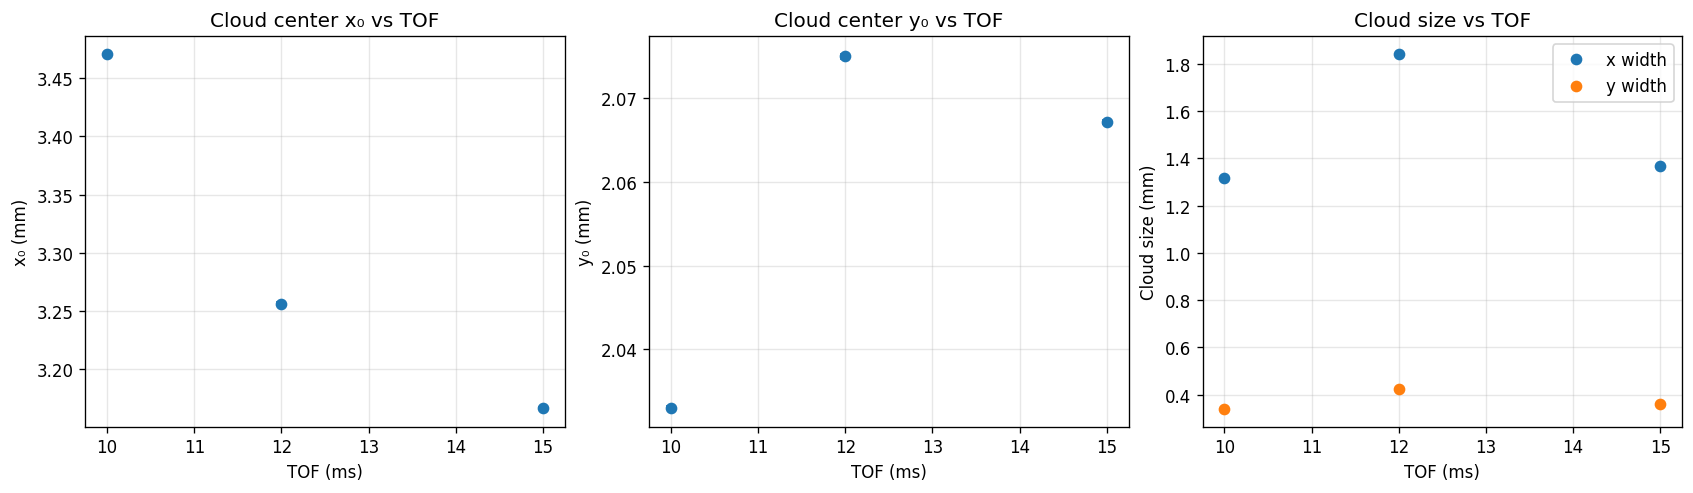

In [32]:
if len(df) >= 2:
    # --- Time axis
    t_ms = df["t_s"].to_numpy() * 1e3

    # --- Positions in object plane (mm)
    x_m = px_to_object_m(
        df["x0_after_px"].to_numpy(),
        pitch_m=PIXEL_PITCH_X_M,
        magnification=MAGNIFICATION,
    )
    y_m = px_to_object_m(
        df["y0_after_px"].to_numpy(),
        pitch_m=PIXEL_PITCH_Y_M,
        magnification=MAGNIFICATION,
    )

    # Position uncertainties (px → m → mm)
    sx_px = df.get("sx0_after_px", pd.Series(np.nan, index=df.index)).to_numpy()
    sy_px = df.get("sy0_after_px", pd.Series(np.nan, index=df.index)).to_numpy()

    sx_m = px_to_object_m(
        np.where(np.isfinite(sx_px), sx_px, 0.0),
        pitch_m=PIXEL_PITCH_X_M,
        magnification=MAGNIFICATION,
    )
    sy_m = px_to_object_m(
        np.where(np.isfinite(sy_px), sy_px, 0.0),
        pitch_m=PIXEL_PITCH_Y_M,
        magnification=MAGNIFICATION,
    )

    # --- Cloud sizes (mm) + rough uncertainties
    wx = df["waist_after_x_mm"].to_numpy()
    wy = df["waist_after_y_mm"].to_numpy()

    # If you stored σ(w0) propagation already, use it; otherwise leave as None
    swx = df.get("swaist_after_x_mm", pd.Series(np.nan, index=df.index)).to_numpy()
    swy = df.get("swaist_after_y_mm", pd.Series(np.nan, index=df.index)).to_numpy()

    # --- Plot
    fig, ax = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

    # (1) x position vs TOF
    ax[0].errorbar(
        t_ms,
        x_m * 1e3,
        yerr=sx_m * 1e3,
        fmt="o",
        capsize=3,
    )
    ax[0].set_xlabel("TOF (ms)")
    ax[0].set_ylabel("x₀ (mm)")
    ax[0].set_title("Cloud center x₀ vs TOF")
    ax[0].grid(True, alpha=0.3)

    # (2) y position vs TOF
    ax[1].errorbar(
        t_ms,
        y_m * 1e3,
        yerr=sy_m * 1e3,
        fmt="o",
        capsize=3,
    )
    ax[1].set_xlabel("TOF (ms)")
    ax[1].set_ylabel("y₀ (mm)")
    ax[1].set_title("Cloud center y₀ vs TOF")
    ax[1].grid(True, alpha=0.3)

    # (3) cloud size vs TOF
    ax[2].errorbar(
        t_ms,
        wx,
        yerr=swx if np.any(np.isfinite(swx)) else None,
        fmt="o",
        label="x width",
        capsize=3,
    )
    ax[2].errorbar(
        t_ms,
        wy,
        yerr=swy if np.any(np.isfinite(swy)) else None,
        fmt="o",
        label="y width",
        capsize=3,
    )
    ax[2].set_xlabel("TOF (ms)")
    ax[2].set_ylabel("Cloud size (mm)")
    ax[2].set_title("Cloud size vs TOF")
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.show()


## 9) MOT atom number summary table

In [33]:
def pm(val, err, fmt="{:.3g}"):
    """Format value ± error safely."""
    if not np.isfinite(val):
        return "—"
    if err is None or not np.isfinite(err):
        return fmt.format(val)
    return f"{fmt.format(val)} ± {fmt.format(err)}"


In [34]:
if len(df) > 0:
    rows = []
    for _, r in df.iterrows():
        rows.append({
            "file": r["file"],
            "t (ms)": pm(r["t_s"] * 1e3, None, "{:.3f}"),

            "max ADU": pm(r["img_max"], None, "{:.1f}"),

            "waist_x (mm)": pm(
                r["waist_after_x_mm"],
                r.get("swaist_after_x_mm", np.nan),
                "{:.3f}",
            ),
            "waist_y (mm)": pm(
                r["waist_after_y_mm"],
                r.get("swaist_after_y_mm", np.nan),
                "{:.3f}",
            ),

            "S_ADU": pm(
                r["S_ADU"],
                r.get("sS_ADU", np.nan),
                "{:.3e}",
            ),

            "K (atoms·s)": pm(
                r["K_atoms_s"],
                r.get("sK_atoms_s", np.nan),
                "{:.3e}",
            ),

            "Natoms": pm(
                r.get("Natoms", np.nan),
                r.get("sNatoms", np.nan),
                "{:.3e}",
            ),
        })

    display(pd.DataFrame(rows))


,file,t (ms),max ADU,waist_x (mm),waist_y (mm),S_ADU,K (atoms·s),Natoms
0,droppic2.txt,10.000,33.0,1.314,0.340,5.699e+04 ± 2.506e+02,2.507e+03 ± 9.792e+02,2.507e+05 ± 1.011e+05
1,drop4photo1.txt,12.000,50.0,1.842,0.424,1.285e+05 ± 5.614e+02,5.655e+03 ± 2.208e+03,5.655e+05 ± 2.280e+05
2,drop5photo1.txt,15.000,50.0,1.368,0.361,8.904e+04 ± 3.866e+02,3.918e+03 ± 1.530e+03,3.918e+05 ± 1.579e+05
